In [3]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
from graphviz import Digraph

def trace(root):
    nodes, edges= set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child,v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root):
    dot= Digraph(format='svg', graph_attr={'rankdir':'LR'})
    nodes, edges= trace(root)
    for n in nodes:
        uid= str(id(n))
        dot.node(name= uid, label= "{data %.4f}" % (n.data, ), shape='record')
        if n._op:
            dot.node(name= uid + n._op, label= n._op)
            dot.edge(uid+n._op, uid)
    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
    return dot

In [7]:
def draw_dot(root):
    dot= Digraph(format='svg', graph_attr={'rankdir':'LR'})
    nodes, edges= trace(root)
    for n in nodes:
        uid= str(id(n))
        dot.node(name= uid, label= "{%s | data %.4f | grad %.4f}" % (n.label, n.data, n.grad), shape='record')
        if n._op:
            dot.node(name= uid + n._op, label= n._op)
            dot.edge(uid+n._op, uid)
    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
    return dot

In [79]:
class Value:

    def __init__(self, data, _children=(), _op='', label=''):
        self.data= data
        self.grad= 0.0
        self._prev= set(_children)
        self._op= _op
        self.label= label
        self._backward= lambda: None

    def __repr__(self):
        return f"Value(data= {self.data})"

    def __add__(self, other):
        if not isinstance(other,Value):
          other=Value(other)
        out= Value(self.data + other.data,(self,other),'+')
        def _backward():
            self.grad+= out.grad * 1.0
            other.grad+= out.grad * 1.0
        out._backward= _backward
        return out
    def __radd__(other,self):
      return self.__add__(other)

    def __mul__(self, other):
        if not isinstance(other,Value):
            other=Value(other)
        out= Value(self.data * other.data,(self,other),'*')
        def _backward():
            self.grad+= out.grad * other.data
            other.grad+= out.grad * self.data
        out._backward= _backward
        return out

    def __rmul__(other,self):
      return self.__mul__(other)

    def __sub__(self,other):
      if not isinstance(other,Value):
            other=Value(other)
      out= Value(self.data - other.data,(self,other),'-')
      def _backward():
            self.grad+= out.grad * 1.0
            other.grad+= out.grad * -1.0
      out._backward= _backward
      return out

    def __rsub__(other,self):
      return self.__sub__(other)

    def __pow__(self, other):
        if not isinstance(other, Value):
            n = Value(n)
        out = Value(self.data ** other.data)
        def _backward():
            self.grad += out.grad * (other.data * self.data**(other.data-1))
        out._backward = _backward
        return out


    def __truediv__(self, other):
        if other.data != 0:
            out = Value(self.data / other.data, (self, other), '/')
            def _backward():
                self.grad += out.grad * (1.0 / other.data)
                other.grad += out.grad * (-self.data / (other.data**2))
            out._backward = _backward
            return out
        else:
            print("Division by zero not possible")
            return None


    def tanh(self):
        x = self.data
        e = Value(math.e)
        t = (e**Value(2*x) - 1) / (e**Value(2*x) + 1)
        out = Value(t.data, (self,), 'tanh')
        def _backward():
            self.grad = out.grad * (1 - t.data**2)
        out._backward = _backward
        return out
    def relu(self):
        return Value(max(0, self.data), (self,), 'relu')

    def backward(self):
        self.grad=1
        for prev in self._prev:
            prev.backward()
            prev=prev._backward()

In [80]:
x1= Value(2.0, label='x1')
x2= Value(0.0, label='x2')
w1= Value(-3.0, label='w1')
w2= Value(1.0, label='w2')
b= Value(6.8813735870195432, label='b')
b1=2
x1w1= x1 * w1; x1w1.label= 'x1 * w1'
x2w2= x2 * w2; x2w2.label= 'x2 * w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label= 'x1*w1 + x2*w2'
n= x1w1x2w2 + b; n.label= 'n'
o= n.tanh(); o.label= 'o';

In [81]:
o

Value(data= 0.7071067811865476)

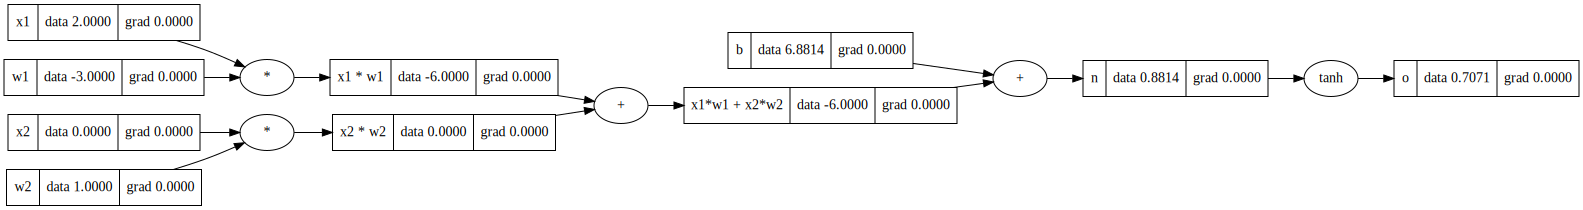

In [82]:
draw_dot(o)

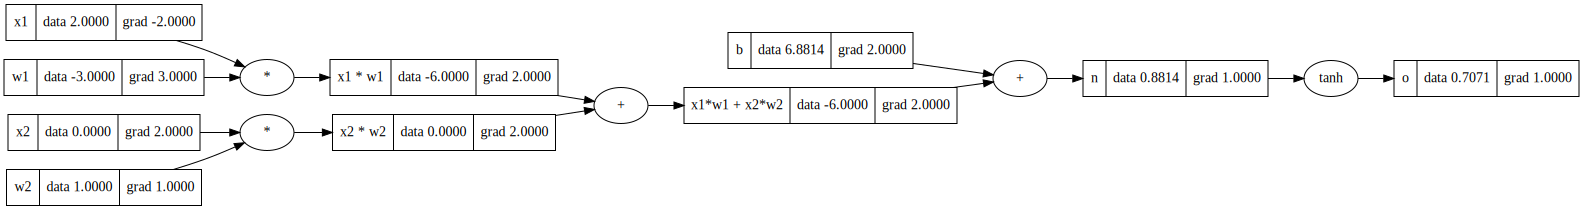

In [83]:
o.backward()
draw_dot(o)